In [ ]:
# Выполнить локально на компьютере
# Скачайте по ссылке	https://sc.link/JpD и распакуйте файл golos_opus.tar (20.5 GB) в папку ~/golos
# Запустите speech_data_explorer на своем компьтере с использованием Docker

docker pull nvcr.io/nvidia/nemo:1.4.0

docker run -itd --ipc=host -p 6001:6006 -v ~/:/workspace/user0 --name nemo_v1.4.0 nvcr.io/nvidia/nemo:1.4.0

docker attach nemo_v1.4.0

cd /workspace/user0 && git clone https://github.com/NVIDIA/NeMo.git

pip install -r /workspace/user0/NeMo/tools/speech_data_explorer/requirements.txt

python /workspace/user0/NeMo/tools/speech_data_explorer/data_explorer.py /workspace/user0/golos/test_opus/crowd/manifest.jsonl --port 6006

# Откройте в браузере http://localhost:6001

SyntaxError: ignored

In [ ]:
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode


## Install NeMo
!python -m pip install nemo_toolkit[all]

# !pip install torchtext==0.10.1
# !pip install matplotlib==3.1.3
"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
exit()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)


In [ ]:
# Папка, где будет размещаться датасет Golos
data_dir = '/content'

In [ ]:
import glob
import os
import subprocess
import tarfile
import wget

# Загрузка датасета Golos
def load(golos_url, fname):
  if not os.path.exists(os.path.join(data_dir, fname)):
      golos_path = wget.download(golos_url, os.path.join(data_dir, fname))
      print(f"Dataset downloaded at: {golos_path}")
  else:
      print("Tarfile already exists.")
      golos_path = os.path.join(data_dir, fname)
  return golos_path

golos_path = load("https://sc.link/Kqr", "test.tar")

if not os.path.exists(os.path.join(data_dir, '/test/')):
    tar = tarfile.open(golos_path)
    tar.extractall(path=data_dir)

Dataset downloaded at: /content/test.tar


Теперь в папке `/content` должна размещаться папка `test` с тестовыми данных датасета Golos. Она содержит файлы манифесты `./test/crowd/manifest.jsonl`, `./test/farfield/manifest.jsonl` и аудио файлы в подпапках `./test/crowd/files/` и `./test/farfield/files/`.

Мы можем загрузить и посмотреть данные. Например файл `./test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav` это четырехсекундная запись мужчины, который произносит фразу `Купить моющее средство`. Чтобы убедиться в этом давайте послушаем запись:

In [ ]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

В задаче распознавания речи, если этот WAV файлявляется нашим входом в систему, то фраза `Купить моющее средство` будет желаемым выходом из системы.

Давайте изобразим форму волны по точкам, которые содержатся в файлах. 
Этот формат отображения аудио, который скорее всего вам знаком, така как используется во многих аудио радакторах и плеерах:

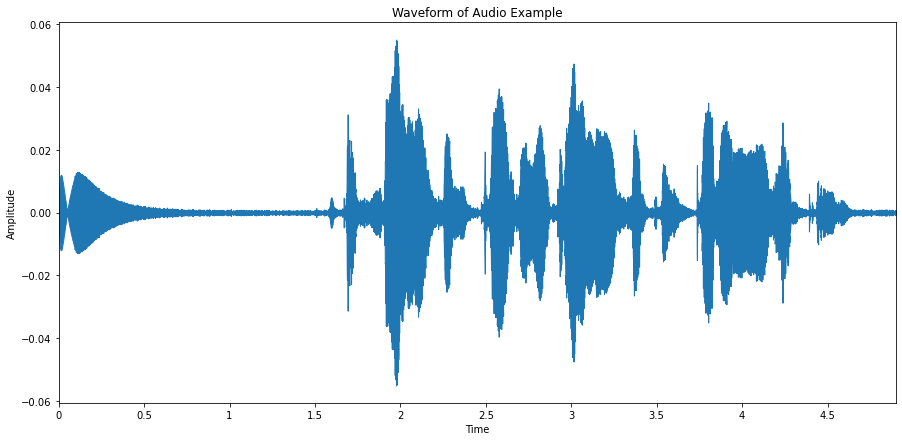

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

### Спектрограмма и мел-спектрограмма

Давайте применим [Фурье преобразование](https://en.wikipedia.org/wiki/Fourier_transform) к аудио сигналу, чтобы получить что то более полезное: **спектрограмму**, которая представляет собой величину энергии (амплитуда или громкость) для каждой частоты (гармоники) сигнала на каждом промежутке времени.

Спектрограмма (которую можно рассматривать как тепловую карту) является хорошим способом увидеть, как *амплитуды различных частот в звуке меняются с течением времени*. Спектрограмма получается путем разбиения сигнала на короткие фреймы, обычно перекрывающиеся и выполнения кратковременного преобразования Фурье (STFT) для каждого из фреймов.

Двайте посмотрим как выглядит спекторграмма для нашего звука. 

In [ ]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

NameError: ignored

Можем сделать еще одну потенциально полезную настройку: использовать **Mel** спектрограмму вместо обычной спектрограммы. Это просто изменение шкалы частот, которую мы используем, с линейной (или логарифмической) на шкалу mel, которая представляет собой "шкалу восприятия тонов, которые слушатели оценивают как равные на расстоянии друг от друга" (из [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

Другими словами, это преобразование частот, чтобы быть более согласованным с тем, что воспринимают люди; изменение +1000 Гц с 2000 Гц->3000 Гц звучит для нас как большая разница, чем 9000 Гц->10000 Гц, поэтому шкала mel нормализует это так, что равные расстояния звучат как равные различия для человеческого уха. Интуитивно мы используем спектрограмму mel, потому что в этом случае мы обрабатываем и расшифровываем человеческую речь, так что преобразование шкалы для лучшего соответствия тому, что мы слышим, является полезной процедурой.

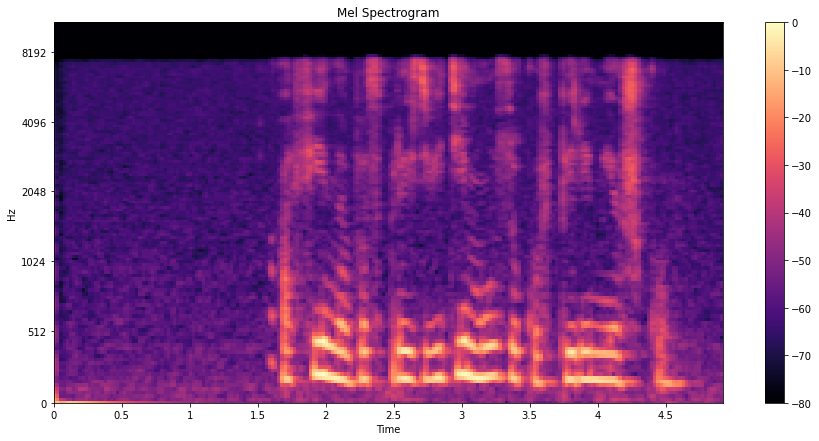

In [ ]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [ ]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   46G   63G  42% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        81G   50G   32G  61% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           100G   41G   60G  41% /content/drive


## Сверточная модель распознавания речи
### Jasper модель

Мы будем тренировать небольшую модель [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288) с нуля (инициализируется случайным образом).
Архитектуры Jasper состоят из повторяющейся блочной структуры, которая использует 1D-свертки.
В модели Jasper_KxR подблоки `R` (состоящие из 1D свертки, batchnorm, ReLU и dropout) группируются в один блок, который затем повторяется `K` раз.
Также есть один дополнительный блок в начале и еще несколько в конце, которые инвариантны к `K` и `R`, идалее используем CTC loss.

### Модель QuartzNet

QuartzNet является улучшенным вариантом Jasper с ключевым отличием в том, что она использует 1D-свертки, разделяемые по временному каналу. Это позволяет ему значительно сократить количество весов при сохранении аналогичной точности.

Модели Jasper/QuartzNet выглядят так (на фото изображена модель QuartzNet):

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)

# Использование NeMo для распонавания речи

Теперь мы знаем что такое задача автоматичского распознавания речи и речевые данные, давайте использовать NeMo для распознавания речи.

Мы будем использовать **Neural Modules (NeMo) toolkit**, поэтому нужно скачать и установить все ее зависимости. Для этого следуйте инструкции в репозитории [GitHub page](https://github.com/NVIDIA/NeMo), или документации [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/).

NeMo позволяет нам легко использовать все необходимые компоненты для нашей модели: dataloader,  промежуточные сверточные или рекурентные слои, разные loss  функции без необходимости разбираться в деталях реализации разных моедлей. В NeMo содержатся готовые реализованные модели в которых достаточно подать свои данные и задать гиперпараметры для обучения.

In [3]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[NeMo W 2021-11-30 16:27:14 optimizers:50] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



## Исползование предобученной модели


Коллекция для распознавания речи в NeMo содержит готовые блоки, которые можно использовать чтобы тренировать и использовать свою модель. Кроме этого существет ряд предобученных моделей, которые можно просто скачать и исползовать. Давайте скачаем и инициализируем готовую модель QuartzNet15x5, обученную на открытом датасете Golos.



In [4]:
# asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_ru_quartznet15x5")

load("https://sc.link/ZMv", "QuartzNet15x5_golos.nemo")
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

Dataset downloaded at: /content/QuartzNet15x5_golos.nemo


[NeMo W 2021-11-30 16:27:19 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: train/golos_and_mcv.jsonl
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 64
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: ru
    
[NeMo W 2021-11-30 16:27:19 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a

[NeMo I 2021-11-30 16:27:19 features:265] PADDING: 16
[NeMo I 2021-11-30 16:27:19 features:282] STFT using torch
[NeMo I 2021-11-30 16:27:32 save_restore_connector:149] Model EncDecCTCModel was successfully restored from /content/QuartzNet15x5_golos.nemo.


Теперь указваем список фалов которые мы хотим транскрибировать и передаем в нашу модель. Это будет работать для относительно коротких аудио (<25 секунд) файлов. 

In [ ]:
files = [data_dir + "/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav",
         data_dir + "/test/crowd/files/5db5df8bb9e3b6660b2a04b34d4a355d.wav"]
transcriptions = asr_model.transcribe(paths2audio_files=files)

for fname, transcription in zip(files, transcriptions):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-11-28 19:21:55 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    
[NeMo W 2021-11-28 19:21:55 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-11-28 19:21:56 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
     

Audio in /content/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav was recognized as: афина воспроизведи музыку вперемешку
Audio in /content/test/crowd/files/5db5df8bb9e3b6660b2a04b34d4a355d.wav was recognized as: найти сериал григорий р


In [ ]:
transcriptions

Это было просто! Но существует масса сценариев, когда мы хотим дообучить модель на наших данных или обучить заново. Например это модель не сможет распознать украинский язык и скоре всего будет плохо распознавать речь в телефонных разговорах. Поэтому, если вы применяете модель на своих данных, то без сомнения, вам нужно дообучать модель на них!

## Обучение 


Для обучения нужно подготовить данные в нужном формате. Для этого добавим абсолютные пути к относительным в наших манифестах и используем их для обучения.

In [5]:
def calculate_wer(reference, hypothesis):
    """
        Calculation of WER with Levenshtein distance.
        Works only for iterables up to 254 elements (uint8).
        O(nm) time and space complexity.

        >>> calculate_wer("who is there".split(), "is there".split())
        1
        >>> calculate_wer("who is there".split(), "".split())
        3
        >>> calculate_wer("".split(), "who is there".split())
        3
    """
    # initialisation
    d = np.zeros((len(reference) + 1) * (len(hypothesis) + 1),
                    dtype=np.uint8)
    d = d.reshape((len(reference) + 1, len(hypothesis) + 1))
    for i in range(len(reference) + 1):
        for j in range(len(hypothesis) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(reference) + 1):
        for j in range(1, len(hypothesis) + 1):
            if reference[i - 1] == hypothesis[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(reference)][len(hypothesis)] / float(len(reference)) 

In [ ]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(manifest_rel, manifest_abs):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            for line in fin:
                metadata = json.loads(line)
                metadata["audio_filepath"]=os.path.join(manifest_path, metadata["audio_filepath"])
                json.dump(metadata, fout)
                fout.write('\n')

# Building Manifests
print("******")
train_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
train_abs = os.path.join(data_dir, 'test/farfield/farfield.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs)
test_manifest = train_abs
print("test_manifest", test_manifest)

train_rel = os.path.join(data_dir, 'test/crowd/manifest.jsonl')
train_abs = os.path.join(data_dir, 'test/crowd/crowd.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)

In [ ]:
# ! head /content/test/farfield/manifest.jsonl
true_transcps = dict()
with open('/content/test/farfield/farfield.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    result = json.loads(json_str)
    true_transcps[result['audio_filepath']] = [result['text']]
    # print(f"result: {result}")
    # print(isinstance(result, dict))
len(true_transcps)
pred_transcr = asr_model.transcribe(paths2audio_files=list(true_transcps.keys()), batch_size=64)

1916

In [ ]:
pred_transcr = asr_model.transcribe(paths2audio_files=list(true_transcps.keys()), batch_size=64)

Transcribing:   0%|          | 0/30 [00:00<?, ?it/s]

[NeMo W 2021-11-28 19:23:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    
[NeMo W 2021-11-28 19:23:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


KeyboardInterrupt: ignored

In [ ]:
pred_transcr[0]

'джой хватит'

In [ ]:
# true_transcps - [0]true_value, [1]pred_value, [2]wer
i = 0
for t in true_transcps:
    wer = calculate_wer(true_transcps[t][0], pred_transcr[i])
    # print(true_transcps[t][0], pred_transcr[i], wer)
    true_transcps[t].append(pred_transcr[i])
    true_transcps[t].append(wer)
    i += 1

In [ ]:
for t in true_transcps:
  if len(true_transcps[t]) != 1:
    print(true_transcps[t])

['джой хватит', 'джой хватит', 0.0]
['салют вызов светлане васильевне николенко', 'салют вызов светлане васильевне николенко', 0.0]
['салют хватит', 'али лат', 0.5833333333333334]
['джой звонок юрию ивановичу царькову', 'джой звонок юрию ивановичу царькову', 0.0]
['джой выйти из сценария', 'джой выйти из сценария', 0.0]
['салют выйти', 'салют выйти', 0.0]
['салют закройся', 'салют закройся', 0.0]
['салют набери данилова', 'салют набери данилова', 0.0]
['сбер мне нравится', 'сбер мне нравится', 0.0]
['салют прекрати', 'салют прекрати', 0.0]
['сбер громче', 'сбер грамче', 0.09090909090909091]
['салют звонок юрию владимировичу волкову', 'салют звонок юрию владимировичу волкову', 0.0]
['афина выйти', 'афина выйти', 0.0]
['сбер выйти из сценария', 'сбер выйти из сценария', 0.0]
['джой приложение сверни', 'джой приложение сверни', 0.0]
['афина закрой приложение', 'афина закрой приложение', 0.0]
['джой надоел', 'джой надоел', 0.0]
['сбер выйди из приложения', 'сбер выйди из приложения', 0.0]


### Задаем модель при помощи YAML конфиг файла


Ниже приведен конфиг файл, давайте рассмотрим его и найдем части описанной архитектуры Jasper. Модель (model) содержит поле под названием `encoder` с под-полем `jasper` который состоит из списка полей. Каждое поле в списке задает конфигурацию блока в нашей моделе. Каждый блок выглядит примерно так:

```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```


Первый элемент в спике соответствует первому блоку в Jasper архитектуре.

Параметры обучающего и тестового датасета в полях (`train_ds`) и (`validation_ds`)

Конфиг в формате YAML позволяем легко и в читаемой форме читать и модифицировать модель без необходимости менять код пррограммы.

### Использование PyTorch Lightning

NeMo модели и модули могуть исползоваться в любом PyTorch проекте где ожидается тип torch.nn.Module.

Однако, NeMo модели созданы на основе [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule, поэтому рекомендуется использовать PytorchLightning для обучения и дообучения (fine-tuning) так как это позволяет легко применять mixed precision и распределенное обучение. Давайте создадим объект Trainer для обучения на GPU 5 эпох.

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=1, precision=16)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
params_model = asr_model._cfg

# --- Config Information ---#
# try:
#     from ruamel.yaml import YAML
# except ModuleNotFoundError:
#     from ruamel_yaml import YAML
# config_path = '/usr/local/lib/python3.7/dist-packages/nemo/collections/asr/models/configs/'

# yaml = YAML(typ='safe')
# with open(config_path) as f:
#     params = yaml.load(f)
# print(params)
params_model['train_ds']['parser']='base'
params_model['validation_ds']['parser']='base'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=16
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=16
params_model['test_ds']['manifest_filepath'] = test_manifest
params_model['test_ds']['batch_size']=16

In [ ]:
params_model

{'sample_rate': 16000, 'repeat': 5, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'optim': {'name': 'novograd', 'lr': 0.05, 'betas': [0.9, 0.98], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'warmup_steps': 500, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}, 'train_ds': {'manifest_filepath': '/content/test/crowd/crowd.jsonl', 'sample_rate': 16000, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'batch_size': 16, 'trim_silence': False, 'max_duration': 20.0, 'min_duration': 0.1, 'num_workers': 20, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter', 'parser': 'base'}, 'validation_ds': {'manifest_filepath': '/content/test/f

In [ ]:
params_model['optim']['lr'] = 0.0001

In [ ]:
params_model['optim']['lr'] = 0.05

Затем мы создадим экземпляр и модель ASR на основе нашего файла ``config.yaml`` из предыдущего раздела. 
Обратите внимание, что это этап, на котором мы также сообщаем модели, где находятся наши обучающие и тестовые манифесты.

In [ ]:
from omegaconf import DictConfig


first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params_model), trainer=trainer)

[NeMo I 2021-11-28 10:36:16 collections:173] Dataset loaded with 9990 files totalling 11.17 hours
[NeMo I 2021-11-28 10:36:16 collections:174] 4 files were filtered totalling 0.03 hours


[NeMo W 2021-11-28 10:36:16 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2021-11-28 10:36:16 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-28 10:36:16 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-28 10:36:16 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-28 10:36:16 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-28 10:36:16 features:265] PADDING: 16
[NeMo I 2021-11-28 10:36:16 features:282] STFT using torch


Мы можем начать обучение всего одной строчкой!

In [ ]:
# Start training!!!
trainer.fit(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-28 10:36:20 modelPT:471] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f45384b7ed0>. We recommend to use 'ddp' instead.


[NeMo I 2021-11-28 10:36:20 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )
[NeMo I 2021-11-28 10:36:20 lr_scheduler:752] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f46afae6250>" 
    will be used during training (effective maximum steps = 625) - 
    Parameters : 
    (warmup_steps: 500
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 625
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-11-28 10:36:21 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-28 10:36:22 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

Training: 0it [00:00, ?it/s]

[NeMo W 2021-11-28 10:36:29 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
      "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
    


Validating: 0it [00:00, ?it/s]

There we go! We've put together a full training pipeline for the model and trained it for 5 epochs.

If you'd like to save this model checkpoint for loading later (e.g. for fine-tuning, or for continuing training), you can simply call `first_asr_model.save_to(<checkpoint_path>)`. Then, to restore your weights, you can rebuild the model using the config (let's say you call it `first_asr_model_continued` this time) and call `first_asr_model_continued.restore_from(<checkpoint_path>)`.

### After Training: Monitoring Progress and Changing Hyperparameters
We can  now start Tensorboard to see how training went. Recall that WER stands for Word Error Rate and so the lower it is, the better.

We could improve this model by playing with hyperparameters. We can look at the current hyperparameters with the following:

In [ ]:
print(params['model']['optim'])

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


Let's say we wanted to change the learning rate. To do so, we can create a `new_opt` dict and set our desired learning rate, then call `<model>.setup_optimization()` with the new optimization parameters.

In [ ]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))
# And then you can invoke trainer.fit(first_asr_model)

[NeMo I 2021-10-11 17:30:50 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-10-11 17:30:50 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fccf7134550>" 
    will be used during training (effective maximum steps = 626) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 626
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'frequency': 1,
  'interval': 'step',
  'monitor': 'val_loss',
  'reduce_on_plateau': False,
  'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7fccf7134550>})

In [ ]:
# Use the smaller learning rate we set before
# first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
first_asr_model.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
first_asr_model.setup_validation_data(val_data_config=params_model['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(first_asr_model)

[NeMo I 2021-10-11 17:42:55 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-10-11 17:42:55 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fccf617e710>" 
    will be used during training (effective maximum steps = 626) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 626
    )
[NeMo I 2021-10-11 17:42:55 audio_to_text_dataset:37] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-10-11 17:42:55 audio_to_text_dataset:37] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-10-11 17:42:55 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-10-11 17:42:55 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-10-11 17:42:55 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fccfd5a35d0>" 
    will be used during training (effective maximum steps = 60) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 60
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 30.8 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.840     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-10-11 17:42:56 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
      f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"
    


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Inference

Let's have a quick look at how one could run inference with NeMo's ASR model.

First, ``EncDecCTCModel`` and its subclasses contain a handy ``transcribe`` method which can be used to simply obtain audio files' transcriptions. It also has batch_size argument to improve performance.

In [ ]:
print(first_asr_model.transcribe(paths2audio_files=files,
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['онапоидит', 'с']


Below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [ ]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16
# Setup the test data loader and make sure the model is on GPU
# first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-23 10:35:26 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


WER = 1.0


This WER is not particularly impressive and could be significantly improved. You could train longer (try 100 epochs) to get a better number. Check out the next section on how to improve it further.

## Model Improvements

You already have all you need to create your own ASR model in NeMo, but there are a few more tricks that you can employ if you so desire. In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

Our toy model does not do spectrogram augmentation. But the real one we got from cloud does:

In [ ]:
print(first_asr_model._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


If you want to enable SpecAugment in your model, make sure your .yaml config file contains 'model/spec_augment' section which looks like the one above.

## Under the Hood

NeMo is open-source and we do all our model development in the open, so you can inspect our code if you wish.

In particular, ``nemo_asr.model.EncDecCTCModel`` is an encoder-decoder model which is constructed using several ``Neural Modules`` taken from ``nemo_asr.modules.`` Here is what its forward pass looks like:
```python
def forward(self, input_signal, input_signal_length):
    processed_signal, processed_signal_len = self.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )
    # Spec augment is not applied during evaluation/testing
    if self.spec_augmentation is not None and self.training:
        processed_signal = self.spec_augmentation(input_spec=processed_signal)
    encoded, encoded_len = self.encoder(audio_signal=processed_signal, length=processed_signal_len)
    log_probs = self.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    return log_probs, encoded_len, greedy_predictions
```
Here:

* ``self.preprocessor`` is an instance of ``nemo_asr.modules.AudioToMelSpectrogramPreprocessor``, which is a neural module that takes audio signal and converts it into a Mel-Spectrogram
* ``self.spec_augmentation`` - is a neural module of type ```nemo_asr.modules.SpectrogramAugmentation``, which implements data augmentation. 
* ``self.encoder`` - is a convolutional Jasper/QuartzNet-like encoder of type ``nemo_asr.modules.ConvASREncoder``
* ``self.decoder`` - is a ``nemo_asr.modules.ConvASRDecoder`` which simply projects into the target alphabet (vocabulary).

Also, ``EncDecCTCModel`` uses the audio dataset class ``nemo_asr.data.AudioToCharDataset`` and CTC loss implemented in ``nemo_asr.losses.CTCLoss``.

You can use these and other neural modules (or create new ones yourself!) to construct new ASR models.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and listen to the audio file
example_file = data_dir + '/drive/MyDrive/Speech/farfield/ffffa3b1f6225317dabec94971ac2e3f.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In [7]:
farfield_data_train = load('https://sc.link/1Z3', 'farfield_data_train.tar')

Dataset downloaded at: /content/farfield_data_train.tar


In [8]:
if not os.path.exists(os.path.join(data_dir, '/train/')):
    tar = tarfile.open(farfield_data_train)
    tar.extractall(path=data_dir)

In [ ]:
farfield_data_train

'/content/farfield_data_train.tar'

In [ ]:
! ls train

farfield


In [ ]:
# Building Manifests
print("******")
train_rel = '/content/drive/MyDrive/train_manifest.jsonl'
train_abs = os.path.join(data_dir, 'train/farfield/farfield.jsonl')
if not os.path.isfile(train_abs):
    build_manifest(train_rel, train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)

******
train_manifest /content/test/farfield/farfield.jsonl


In [ ]:
farfield_names = set(os.listdir('/content/train/farfield'))
len(farfield_names)
farfield_names

In [ ]:
# ! head /content/train/farfield/farfield.jsonl
true_transcps = list()
with open('/content/train_farfield_new.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    result = json.loads(json_str)
    # if result['audio_filepath'] in farfield_names:
    true_transcps.append()
    # true_transcps[result['audio_filepath']] = [result['text']]
    # print(f"result: {result}")
    # print(isinstance(result, dict))
len(true_transcps)

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


1103799

In [ ]:
pred_transcr = asr_model.transcribe(paths2audio_files=list(true_transcps.keys()), batch_size=64)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
files = os.listdir('/content/drive/MyDrive/Speech/farfield/')
len(files)

124003

In [ ]:
! ls /content/drive/MyDrive/Speech/farfield/ | grep ffffa3b1f6225317dabec94971ac2e3f.wav

ffffa3b1f6225317dabec94971ac2e3f.wav


In [ ]:
train_fairfield = dict()

In [ ]:
# ! head /content/test/farfield/manifest.jsonl
import json
true_transcps = dict()

with open('/content/train_manifest.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    result = json.loads(json_str)
    if 'farfield' in result['audio_filepath']:
        train_fairfield['/content/drive/MyDrive/Speech/' + result['audio_filepath']] = [result['text']]
    #true_transcps[result['audio_filepath']] = [result['text']]
    # print(f"result: {result}")
    # print(isinstance(result, dict))
len(train_fairfield)

124003

In [ ]:
train_fairfield['/content/drive/MyDrive/Speech/farfield/4f1970010a019c5146d1b2297e8489b0.wav'][0]

'салют сколько всего туполев в ту сто четырнадцать'

In [ ]:
import json
with open('train_fairfield.json', 'w') as f:
    json.dump(train_fairfield, f)

In [ ]:
with open('train_fairfield_full.txt', 'a') as outfile:
    for hostDict in train_fairfield:
        json.dump(hostDict, outfile)
        outfile.write(':')
        json.dump(train_fairfield[hostDict], outfile)
        outfile.write('\n')

In [ ]:
true_transcps = list()
files = list()
with open('/content/train_farfield_new.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    result = json.loads(json_str)
    if result['text'] != '' and result['text'] != ' ':
        files.append(result['audio_filepath'])
        true_transcps.append(result['text'])

In [ ]:
files

In [ ]:
pred_transcr = asr_model.transcribe(paths2audio_files=files, batch_size=64)

Transcribing:   0%|          | 0/1818 [00:00<?, ?it/s]

[NeMo W 2021-11-30 12:24:27 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


In [ ]:
pred_transcr

In [ ]:
import numpy as np
good = []
for t in range(len(pred_transcr)):
    wer = calculate_wer(pred_transcr[t], true_transcps[t])
    if wer < 0.05:
        good.append(files[t])
    if t % 1000 == 0:
        print(t)

In [ ]:
good

In [ ]:
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

FileNotFoundError: ignored

In [ ]:
len(list(train_fairfield.keys()))

124003

In [ ]:
len(list(pred_transcr))

5000

In [ ]:
good_set = set(good)

In [ ]:
textfile = open("pred_transcr.txt", "w")
for element in pred_transcr:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
keys = list(train_fairfield.keys())[:5000]
pairs = []
for i in range(len(keys)):
    pairs.append([train_fairfield[keys[i]][0], pred_transcr[i], keys[i]])

In [ ]:
for t in range(len(pairs)):
    wer = calculate_wer(pairs[t][0], pairs[t][1])
    if wer > 0:
        print(pairs[t][0], ':', pairs[t][1], wer)

In [ ]:
# ! head /content/test/farfield/manifest.jsonl
import json
true_transcps = dict()

with open('/content/train_farfield_new.jsonl', 'r') as json_file:
    json_list = list(json_file)

fout = open('train_farfield_new_filltered.jsonl', 'w')

for json_str in json_list:
    result = json.loads(json_str)
    if result['audio_filepath'] in good_set:
        json.dump(result, fout)
        fout.write('\n')

In [11]:
def build_manifest(manifest_rel, manifest_abs):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            for line in fin:
                metadata = json.loads(line)
                metadata["audio_filepath"]=os.path.join('/content/test/farfield/', metadata["audio_filepath"])
                json.dump(metadata, fout)
                fout.write('\n')

In [10]:
import json
import os
#'/content/train/'
train_rel = '/content/train_farfield.jsonl'
train_abs = '/content/train_farfield_new.jsonl'
build_manifest(train_rel, train_abs)
train_manifest = train_abs

In [12]:
import json
import os
#'/content/test/farfield/'
train_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
train_abs = os.path.join(data_dir, 'test/farfield/farfield.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs)
test_manifest = train_abs

In [13]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=1, precision=16, default_root_dir="/content/drive/MyDrive/checkpoints")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
test_manifest

'/content/test/farfield/farfield.jsonl'

In [ ]:

asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

[NeMo W 2021-11-30 07:23:20 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: train/golos_and_mcv.jsonl
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 64
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: ru
    
[NeMo W 2021-11-30 07:23:20 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a

[NeMo I 2021-11-30 07:23:20 features:265] PADDING: 16
[NeMo I 2021-11-30 07:23:20 features:282] STFT using torch
[NeMo I 2021-11-30 07:23:21 save_restore_connector:149] Model EncDecCTCModel was successfully restored from /content/QuartzNet15x5_golos.nemo.


In [21]:
params_model = third_asr_model._cfg

# --- Config Information ---#
# try:
#     from ruamel.yaml import YAML
# except ModuleNotFoundError:
#     from ruamel_yaml import YAML
# config_path = '/usr/local/lib/python3.7/dist-packages/nemo/collections/asr/models/configs/'

# yaml = YAML(typ='safe')
# with open(config_path) as f:
#     params = yaml.load(f)
# print(params)
params_model['train_ds']['parser']='base'
params_model['validation_ds']['parser']='base'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=16
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=16
params_model['test_ds']['manifest_filepath'] = test_manifest
params_model['test_ds']['batch_size']=16
params_model['optim']['lr'] = 0.0005

In [22]:
params_model

{'sample_rate': 16000, 'repeat': 5, 'dropout': 0.8, 'separable': True, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'optim': {'name': 'novograd', 'lr': 0.0005, 'betas': [0.9, 0.98], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'warmup_steps': 500, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}, 'train_ds': {'manifest_filepath': '/content/train_farfield_new.jsonl', 'sample_rate': 16000, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'batch_size': 16, 'trim_silence': False, 'max_duration': 20.0, 'min_duration': 0.1, 'num_workers': 20, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter', 'parser': 'base'}, 'validation_ds': {'manifest_filepath': '/content/te

In [29]:
from omegaconf import DictConfig

five_asr_model = third_asr_model

In [30]:
import copy
opt = copy.deepcopy(params_model['optim'])
opt['lr'] = 0.0001
five_asr_model.setup_optimization(optim_config=DictConfig(opt))

[NeMo W 2021-11-30 18:05:33 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-30 18:05:33 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-30 18:05:33 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.9, 0.98]
     eps: 1e-08
     grad_averaging: False
     lr: 0.0001
     weight_decay: 0.001
 ), None)

In [31]:
five_asr_model.setup_training_data(train_data_config=params_model['train_ds'])
five_asr_model.setup_test_data(test_data_config=params_model['test_ds'])
# Point to the new validation data for fine-tuning
five_asr_model.setup_validation_data(val_data_config=params_model['validation_ds'])

[NeMo I 2021-11-30 18:05:37 collections:173] Dataset loaded with 123995 files totalling 132.43 hours
[NeMo I 2021-11-30 18:05:37 collections:174] 8 files were filtered totalling 0.03 hours


[NeMo W 2021-11-30 18:05:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2021-11-30 18:05:37 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-30 18:05:37 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-30 18:05:37 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-30 18:05:37 collections:174] 0 files were filtered totalling 0.00 hours


In [32]:
trainer.fit(five_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-30 18:05:37 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-30 18:05:37 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-30 18:05:37 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)
[NeMo W 2021-11-30 18:05:38 nemo_logging:349] /usr/loc

Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-11-30 18:05:38 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-30 18:05:39 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [33]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16
# Setup the test data loader and make sure the model is on GPU
# third_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
five_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in five_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = five_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        five_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = five_asr_model._wer.compute()
        five_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-30 19:22:14 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


WER = 0.5229062276306371


In [28]:
fourth_asr_model.save_to('/content/drive/MyDrive/model_first_50000_3.nemo')

In [15]:
third_asr_model = nemo_asr.models.EncDecCTCModel.restore_from('/content/drive/MyDrive/model_first_50000_2.nemo')

[NeMo W 2021-11-30 16:41:00 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/train_farfield_new.jsonl
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 16
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: base
    
[NeMo W 2021-11-30 16:41:00 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and

[NeMo I 2021-11-30 16:41:00 features:265] PADDING: 16
[NeMo I 2021-11-30 16:41:00 features:282] STFT using torch
[NeMo I 2021-11-30 16:41:01 save_restore_connector:149] Model EncDecCTCModel was successfully restored from /content/drive/MyDrive/model_first_50000_2.nemo.


In [ ]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16
# Setup the test data loader and make sure the model is on GPU
# third_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model._wer.compute()
        asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-30 12:22:34 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


WER = 0.6612980195657361
